# Let's Build a Quant Trading Strategy

In [204]:
# signal = model(x)
# orders = strategy(signal)
# execute(orders)

In [205]:
# In the last video, we built a model that predicts what the log return will be eight hours from now.

In [206]:
# This video is about strategy development based on our model

In [207]:
# I tried to make it accessible even if you haven't watched part 1.

In [208]:
# I changed the model as it not predicts 12 hours ahead and not 8h. Simple reason is to increase our time horizon so the fees don't eat as much into our profits.

In [209]:
# The model uses lag 1, lag 2 and lag 3. We will go into more detail about the model.

### type of strategies 

In [210]:
# 1 Maker strategies => they are providing liquidity => adding liquidity to a market and aim to be compensated for it
# 2 Taker strategies => they taking away liquidity => market orders that consume liquidity => what we are going to focus on

In [211]:
# Key Questions for our taking strategy

# 1. Entry/exit timing?
# 2. Trade Size
# 3. Use Leverage?
# 4. Use take-profit orders?
# 5. Use stop-loss orders?



In [212]:
## the key goal is we want to create a strategy that increases profits from the model's edge

### import the libraries

In [213]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities


### research parameters

In [214]:
sym = 'BTCUSDT'
time_interval = '12h'
download_window = 7 * 4 * 7 # roughly 6 months
forecast_horizon = 1
test_size = 0.25

### load the model 

In [215]:
import models
model = models.LinearModel(3)
# security alert 
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

LinearModel(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)

### interpreted as a mean reversion model

In [216]:
series = [-0.014000, 0.011399, -0.012212, 0.01997, -0.01442, 0.01227]
mu = np.mean(series)
mean_reversion_df = pl.DataFrame({'log_return': series, 'mean': mu})
mean_reversion_df

log_return,mean
f64,f64
-0.014,0.000501
0.011399,0.000501
-0.012212,0.000501
0.01997,0.000501
-0.01442,0.000501
0.01227,0.000501


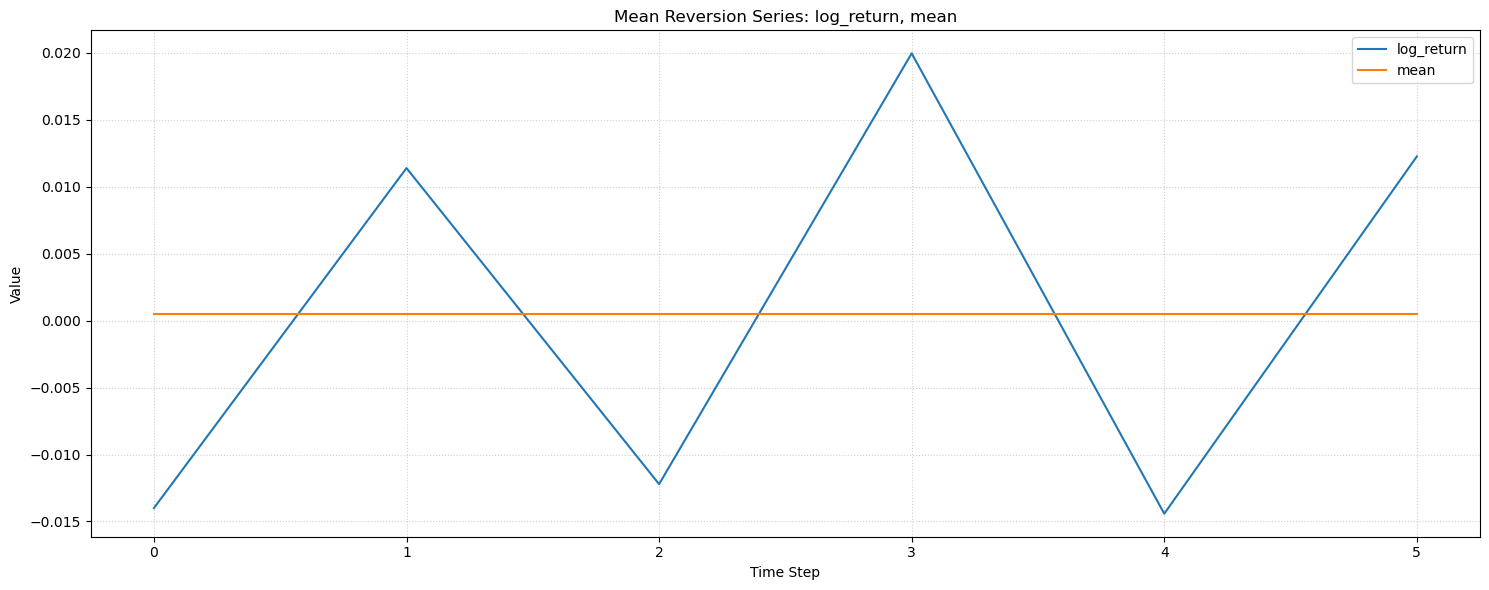

In [217]:
research.plot_multiple_lines(mean_reversion_df, ['log_return','mean'], 'Mean Reversion')

### model parameters

In [218]:
research.print_model_params(model)

linear.weight:
[[-0.10395038 -0.06726477  0.02827305]]
linear.bias:
[0.00067121]


### 🧩 Interpretation

- **w₁ = –0.10** → The last observation (*yₜ₋₁*) has a slight negative relationship:  
  if it went up by 1, the current value tends to go down by about 0.10 (all else equal).

- **w₂ = –0.07** → The value two steps ago also has a small negative influence.

- **w₃ = +0.03** → The value three steps ago has a small positive effect.

model = mean-reverting dynamics — recent values push future ones in the opposite direction a little, with diminishing influence up to three lags

### interpretability of linear model

In [219]:
def linear_model(x):
    w, b = -0.09911217, 0.00059838
    return w * x + b

linear_model(-0.015) 

0.00208506255

In [220]:
linear_model(0.02) 

-0.0013838634

In [221]:
linear_model(0.000002)

0.00059818177566

In [222]:
linear_model(0.0)

0.00059838

### interpretability of a neural network

In [223]:
def nn_model(x):
    x = torch.tensor([x])
    W = torch.tensor([0.08035, -0.01478, -0.03523,  0.06777,  0.03789,  0.0013991, -0.13303,  0.8045])
    b = torch.tensor([0.16421])
    return torch.tanh(torch.sum(x * W) + b)

nn_model(-0.015)

tensor([0.1509])

In [224]:
# no interability
nn_model(0.02)

tensor([0.1785])

In [225]:
nn_model(0.0)

tensor([0.1627])

In [226]:
# not disparaging neural networks as my background is neural networks 
# but for trading, neural networks can increase your expected value but at the expense of complexity
# linear models are not sensitive to noise, they are interpretible, less prone to overfit (generalization)

## Strategy Development!

### load time series data

In [227]:
# binance.download_trades(sym, download_window)

In [228]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 195/195 [00:10<00:00, 18.88file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-03-29 00:00:00,84380.8,84589.7,81963.0,82255.1
2025-03-29 12:00:00,82255.1,82839.9,81601.0,82604.7
2025-03-30 00:00:00,82604.8,83490.0,82450.9,83080.0
2025-03-30 12:00:00,83080.0,83229.6,81501.4,82352.8
2025-03-31 00:00:00,82353.1,82416.0,81222.0,82171.5
…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5


### add log return target and its auto-regressive lags

In [229]:
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=3)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-03-29 00:00:00,84380.8,84589.7,81963.0,82255.1,null,null,null,null
2025-03-29 12:00:00,82255.1,82839.9,81601.0,82604.7,0.004241,null,null,null
2025-03-30 00:00:00,82604.8,83490.0,82450.9,83080.0,0.005737,0.004241,null,null
2025-03-30 12:00:00,83080.0,83229.6,81501.4,82352.8,-0.008792,0.005737,0.004241,null
2025-03-31 00:00:00,82353.1,82416.0,81222.0,82171.5,-0.002204,-0.008792,0.005737,0.004241
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858


### use most recent data to develop the strategy

In [230]:
_, test_trades = research.timeseries_split(ts, test_size)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,113485.9,112130.3,112272.8,-0.001686,-0.005657,-0.009857,0.005205
2025-08-22 12:00:00,112272.9,117397.4,111625.9,116897.5,0.040366,-0.001686,-0.005657,-0.009857
2025-08-23 00:00:00,116897.5,116988.0,115180.0,115266.7,-0.014049,0.040366,-0.001686,-0.005657
2025-08-23 12:00:00,115266.8,115450.0,114510.0,115377.1,0.000957,-0.014049,0.040366,-0.001686
2025-08-24 00:00:00,115377.1,115640.0,114574.1,114702.0,-0.005868,0.000957,-0.014049,0.040366
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858


## Strategy Decision #1. What's our entry and exit signal?

In [231]:
# q1: when do we get in? entry signal
# q2: when do we get out? exit signal

In [232]:
# 1. Time Based 
# 2. Predicate Based 

In [233]:
# 00:00 -> trade to create a BTCUSDT position based on our prediction
# 12:00 -> trade to close the existing BTCUSDT position, trade to enter a new position on the current log return (00:00 -> 12:00) prediction
# 00:00 -> trade to close the existing BTCUSDT pos, trade to enter a new position on the current log return (12:00 -> 00:00) prediction

In [234]:
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,113485.9,112130.3,112272.8,-0.001686,-0.005657,-0.009857,0.005205
2025-08-22 12:00:00,112272.9,117397.4,111625.9,116897.5,0.040366,-0.001686,-0.005657,-0.009857
2025-08-23 00:00:00,116897.5,116988.0,115180.0,115266.7,-0.014049,0.040366,-0.001686,-0.005657
2025-08-23 12:00:00,115266.8,115450.0,114510.0,115377.1,0.000957,-0.014049,0.040366,-0.001686
2025-08-24 00:00:00,115377.1,115640.0,114574.1,114702.0,-0.005868,0.000957,-0.014049,0.040366
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858


### add model's predictions to our trades

In [235]:
target = 'close_log_return'
features = [f'{target}_lag_1',f'{target}_lag_2',f'{target}_lag_3']
test_trades = research.add_model_predictions(test_trades, model, features)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32
2025-08-22 00:00:00,112462.2,113485.9,112130.3,112272.8,-0.001686,-0.005657,-0.009857,0.005205,0.002069
2025-08-22 12:00:00,112272.9,117397.4,111625.9,116897.5,0.040366,-0.001686,-0.005657,-0.009857,0.000948
2025-08-23 00:00:00,116897.5,116988.0,115180.0,115266.7,-0.014049,0.040366,-0.001686,-0.005657,-0.003571
2025-08-23 12:00:00,115266.8,115450.0,114510.0,115377.1,0.000957,-0.014049,0.040366,-0.001686,-0.000631
2025-08-24 00:00:00,115377.1,115640.0,114574.1,114702.0,-0.005868,0.000957,-0.014049,0.040366,0.002658
…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011


### add directional signal

In [236]:
test_trades = test_trades.with_columns(pl.col('y_hat').sign().alias('dir_signal'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32
2025-08-22 00:00:00,112462.2,113485.9,112130.3,112272.8,-0.001686,-0.005657,-0.009857,0.005205,0.002069,1.0
2025-08-22 12:00:00,112272.9,117397.4,111625.9,116897.5,0.040366,-0.001686,-0.005657,-0.009857,0.000948,1.0
2025-08-23 00:00:00,116897.5,116988.0,115180.0,115266.7,-0.014049,0.040366,-0.001686,-0.005657,-0.003571,-1.0
2025-08-23 12:00:00,115266.8,115450.0,114510.0,115377.1,0.000957,-0.014049,0.040366,-0.001686,-0.000631,-1.0
2025-08-24 00:00:00,115377.1,115640.0,114574.1,114702.0,-0.005868,0.000957,-0.014049,0.040366,0.002658,1.0
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0


### calculate trade log return

In [237]:
test_trades = test_trades.with_columns((pl.col('close_log_return')*pl.col('dir_signal')).alias('trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64
2025-08-22 00:00:00,112462.2,113485.9,112130.3,112272.8,-0.001686,-0.005657,-0.009857,0.005205,0.002069,1.0,-0.001686
2025-08-22 12:00:00,112272.9,117397.4,111625.9,116897.5,0.040366,-0.001686,-0.005657,-0.009857,0.000948,1.0,0.040366
2025-08-23 00:00:00,116897.5,116988.0,115180.0,115266.7,-0.014049,0.040366,-0.001686,-0.005657,-0.003571,-1.0,0.014049
2025-08-23 12:00:00,115266.8,115450.0,114510.0,115377.1,0.000957,-0.014049,0.040366,-0.001686,-0.000631,-1.0,-0.000957
2025-08-24 00:00:00,115377.1,115640.0,114574.1,114702.0,-0.005868,0.000957,-0.014049,0.040366,0.002658,1.0,-0.005868
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0,-0.025324
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0,0.012611
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0,0.003347


### calculate cumulative trade log return

In [238]:
test_trades = test_trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64
2025-08-22 00:00:00,112462.2,113485.9,112130.3,112272.8,-0.001686,-0.005657,-0.009857,0.005205,0.002069,1.0,-0.001686,-0.001686
2025-08-22 12:00:00,112272.9,117397.4,111625.9,116897.5,0.040366,-0.001686,-0.005657,-0.009857,0.000948,1.0,0.040366,0.03868
2025-08-23 00:00:00,116897.5,116988.0,115180.0,115266.7,-0.014049,0.040366,-0.001686,-0.005657,-0.003571,-1.0,0.014049,0.052729
2025-08-23 12:00:00,115266.8,115450.0,114510.0,115377.1,0.000957,-0.014049,0.040366,-0.001686,-0.000631,-1.0,-0.000957,0.051772
2025-08-24 00:00:00,115377.1,115640.0,114574.1,114702.0,-0.005868,0.000957,-0.014049,0.040366,0.002658,1.0,-0.005868,0.045903
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0,-0.025324,0.156545
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0,0.012611,0.169155
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0,0.003347,0.172503


### equity curve (log space)

In [239]:
research.plot_column(test_trades, 'cum_trade_log_return')

alt.Chart(...)

## key strategy decision #2: trade sizing

### constant trade value

In [240]:
view_cols = [
    'datetime',
    'open',
    'close_log_return',
    'y_hat',
    'dir_signal',
    'trade_log_return',
    'cum_trade_log_return',
    'pre_trade_value',
    'post_trade_value',
    'trade_qty',
    'signed_trade_qty',
]

In [241]:
capital = 100
trade_value = capital
test_trades = test_trades.with_columns(
    pl.lit(trade_value).alias('pre_trade_value'),
    (trade_value * pl.col('trade_log_return').exp()).alias('post_trade_value'),
    (trade_value / pl.col('open')).alias('trade_qty'),
).with_columns(
    (pl.col('trade_qty') * pl.col('dir_signal')).alias('signed_trade_qty'),
)

test_trades.select(view_cols)

datetime,open,close_log_return,y_hat,dir_signal,trade_log_return,cum_trade_log_return,pre_trade_value,post_trade_value,trade_qty,signed_trade_qty
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64,f64
2025-08-22 00:00:00,112462.2,-0.001686,0.002069,1.0,-0.001686,-0.001686,100,99.831588,0.000889,0.000889
2025-08-22 12:00:00,112272.9,0.040366,0.000948,1.0,0.040366,0.03868,100,104.119163,0.000891,0.000891
2025-08-23 00:00:00,116897.5,-0.014049,-0.003571,-1.0,0.014049,0.052729,100,101.414806,0.000855,-0.000855
2025-08-23 12:00:00,115266.8,0.000957,-0.000631,-1.0,-0.000957,0.051772,100,99.904314,0.000868,-0.000868
2025-08-24 00:00:00,115377.1,-0.005868,0.002658,1.0,-0.005868,0.045903,100,99.414875,0.000867,0.000867
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,-0.025324,0.000779,1.0,-0.025324,0.156545,100,97.499381,0.000804,0.000804
2025-10-08 00:00:00,121286.6,0.012611,0.003535,1.0,0.012611,0.169155,100,101.269061,0.000824,0.000824
2025-10-08 12:00:00,122825.8,0.003347,0.001011,1.0,0.003347,0.172503,100,100.335272,0.000814,0.000814


### add trade gross pnl

In [242]:
test_trades = test_trades.with_columns((pl.col('post_trade_value') - pl.col('pre_trade_value')).alias('trade_gross_pnl'))
if 'trade_gross_pnl' not in view_cols: view_cols.append('trade_gross_pnl')
test_trades.select(view_cols)

datetime,open,close_log_return,y_hat,dir_signal,trade_log_return,cum_trade_log_return,pre_trade_value,post_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,-0.001686,0.002069,1.0,-0.001686,-0.001686,100,99.831588,0.000889,0.000889,-0.168412
2025-08-22 12:00:00,112272.9,0.040366,0.000948,1.0,0.040366,0.03868,100,104.119163,0.000891,0.000891,4.119163
2025-08-23 00:00:00,116897.5,-0.014049,-0.003571,-1.0,0.014049,0.052729,100,101.414806,0.000855,-0.000855,1.414806
2025-08-23 12:00:00,115266.8,0.000957,-0.000631,-1.0,-0.000957,0.051772,100,99.904314,0.000868,-0.000868,-0.095686
2025-08-24 00:00:00,115377.1,-0.005868,0.002658,1.0,-0.005868,0.045903,100,99.414875,0.000867,0.000867,-0.585125
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,-0.025324,0.000779,1.0,-0.025324,0.156545,100,97.499381,0.000804,0.000804,-2.500619
2025-10-08 00:00:00,121286.6,0.012611,0.003535,1.0,0.012611,0.169155,100,101.269061,0.000824,0.000824,1.269061
2025-10-08 12:00:00,122825.8,0.003347,0.001011,1.0,0.003347,0.172503,100,100.335272,0.000814,0.000814,0.335272


### add round trip transaction fees

In [243]:
test_trades = test_trades.with_columns((pl.col('pre_trade_value')*binance.TAKER_FEE+pl.col('post_trade_value')*binance.TAKER_FEE).alias('tx_fees'))
if 'tx_fees' not in view_cols: view_cols.append('tx_fees')
test_trades.select(view_cols)

datetime,open,close_log_return,y_hat,dir_signal,trade_log_return,cum_trade_log_return,pre_trade_value,post_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,tx_fees
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,-0.001686,0.002069,1.0,-0.001686,-0.001686,100,99.831588,0.000889,0.000889,-0.168412,0.059949
2025-08-22 12:00:00,112272.9,0.040366,0.000948,1.0,0.040366,0.03868,100,104.119163,0.000891,0.000891,4.119163,0.061236
2025-08-23 00:00:00,116897.5,-0.014049,-0.003571,-1.0,0.014049,0.052729,100,101.414806,0.000855,-0.000855,1.414806,0.060424
2025-08-23 12:00:00,115266.8,0.000957,-0.000631,-1.0,-0.000957,0.051772,100,99.904314,0.000868,-0.000868,-0.095686,0.059971
2025-08-24 00:00:00,115377.1,-0.005868,0.002658,1.0,-0.005868,0.045903,100,99.414875,0.000867,0.000867,-0.585125,0.059824
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,-0.025324,0.000779,1.0,-0.025324,0.156545,100,97.499381,0.000804,0.000804,-2.500619,0.05925
2025-10-08 00:00:00,121286.6,0.012611,0.003535,1.0,0.012611,0.169155,100,101.269061,0.000824,0.000824,1.269061,0.060381
2025-10-08 12:00:00,122825.8,0.003347,0.001011,1.0,0.003347,0.172503,100,100.335272,0.000814,0.000814,0.335272,0.060101


### calculate trade net pnl

In [244]:
test_trades = test_trades.with_columns((pl.col('trade_gross_pnl')-pl.col('tx_fees')).alias('trade_net_pnl'))
if 'trade_net_pnl' not in view_cols: view_cols.append('trade_net_pnl')
test_trades.select(view_cols)

datetime,open,close_log_return,y_hat,dir_signal,trade_log_return,cum_trade_log_return,pre_trade_value,post_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,tx_fees,trade_net_pnl
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,-0.001686,0.002069,1.0,-0.001686,-0.001686,100,99.831588,0.000889,0.000889,-0.168412,0.059949,-0.228362
2025-08-22 12:00:00,112272.9,0.040366,0.000948,1.0,0.040366,0.03868,100,104.119163,0.000891,0.000891,4.119163,0.061236,4.057928
2025-08-23 00:00:00,116897.5,-0.014049,-0.003571,-1.0,0.014049,0.052729,100,101.414806,0.000855,-0.000855,1.414806,0.060424,1.354381
2025-08-23 12:00:00,115266.8,0.000957,-0.000631,-1.0,-0.000957,0.051772,100,99.904314,0.000868,-0.000868,-0.095686,0.059971,-0.155658
2025-08-24 00:00:00,115377.1,-0.005868,0.002658,1.0,-0.005868,0.045903,100,99.414875,0.000867,0.000867,-0.585125,0.059824,-0.644949
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,-0.025324,0.000779,1.0,-0.025324,0.156545,100,97.499381,0.000804,0.000804,-2.500619,0.05925,-2.559869
2025-10-08 00:00:00,121286.6,0.012611,0.003535,1.0,0.012611,0.169155,100,101.269061,0.000824,0.000824,1.269061,0.060381,1.208681
2025-10-08 12:00:00,122825.8,0.003347,0.001011,1.0,0.003347,0.172503,100,100.335272,0.000814,0.000814,0.335272,0.060101,0.275171


### compute constant size equity curves

In [245]:
test_trades = test_trades.with_columns(
    (capital+(pl.col('trade_net_pnl').cum_sum())).alias('equity_curve_net'),
    (capital+(pl.col('trade_gross_pnl').cum_sum())).alias('equity_curve_gross')
)
if 'equity_curve_net' not in view_cols: view_cols.append('equity_curve_net')
test_trades.select(['close']+view_cols)

close,datetime,open,close_log_return,y_hat,dir_signal,trade_log_return,cum_trade_log_return,pre_trade_value,post_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,tx_fees,trade_net_pnl,equity_curve_net
f64,datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64,f64,f64,f64,f64,f64
112272.8,2025-08-22 00:00:00,112462.2,-0.001686,0.002069,1.0,-0.001686,-0.001686,100,99.831588,0.000889,0.000889,-0.168412,0.059949,-0.228362,99.771638
116897.5,2025-08-22 12:00:00,112272.9,0.040366,0.000948,1.0,0.040366,0.03868,100,104.119163,0.000891,0.000891,4.119163,0.061236,4.057928,103.829566
115266.7,2025-08-23 00:00:00,116897.5,-0.014049,-0.003571,-1.0,0.014049,0.052729,100,101.414806,0.000855,-0.000855,1.414806,0.060424,1.354381,105.183947
115377.1,2025-08-23 12:00:00,115266.8,0.000957,-0.000631,-1.0,-0.000957,0.051772,100,99.904314,0.000868,-0.000868,-0.095686,0.059971,-0.155658,105.02829
114702.0,2025-08-24 00:00:00,115377.1,-0.005868,0.002658,1.0,-0.005868,0.045903,100,99.414875,0.000867,0.000867,-0.585125,0.059824,-0.644949,104.383341
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
121286.5,2025-10-07 12:00:00,124397.1,-0.025324,0.000779,1.0,-0.025324,0.156545,100,97.499381,0.000804,0.000804,-2.500619,0.05925,-2.559869,110.532028
122825.7,2025-10-08 00:00:00,121286.6,0.012611,0.003535,1.0,0.012611,0.169155,100,101.269061,0.000824,0.000824,1.269061,0.060381,1.208681,111.740709
123237.5,2025-10-08 12:00:00,122825.8,0.003347,0.001011,1.0,0.003347,0.172503,100,100.335272,0.000814,0.000814,0.335272,0.060101,0.275171,112.01588


### display the gross equity curve for static trade sizes

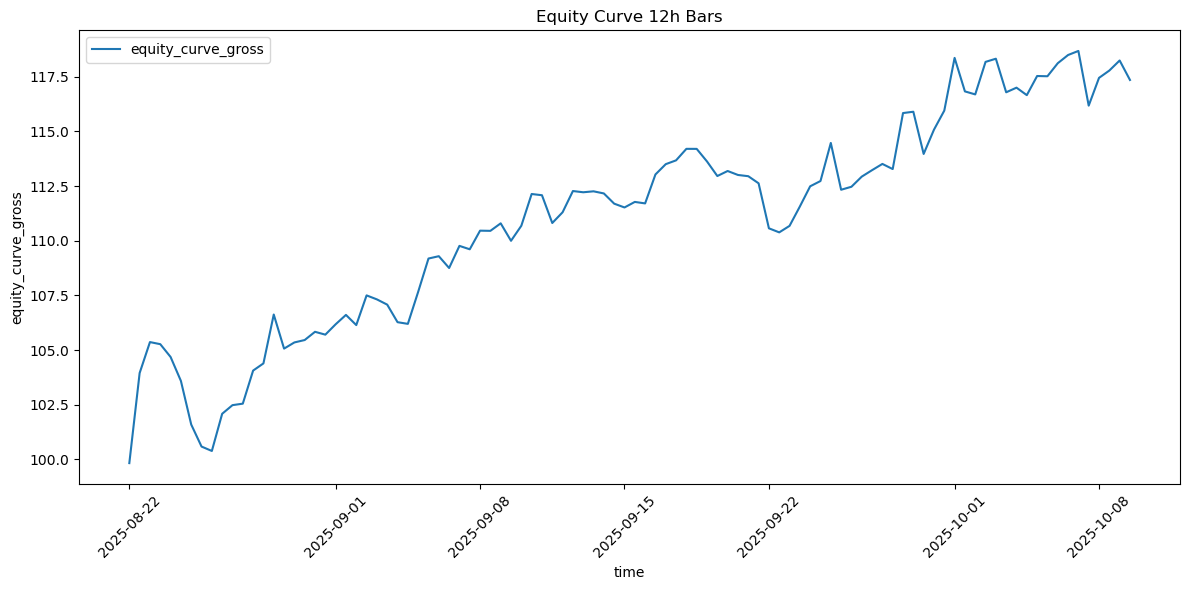

In [246]:
research.plot_static_timeseries(test_trades, 'Equity Curve', 'equity_curve_gross', time_interval)

### display the net equity curve for constant trade sizes

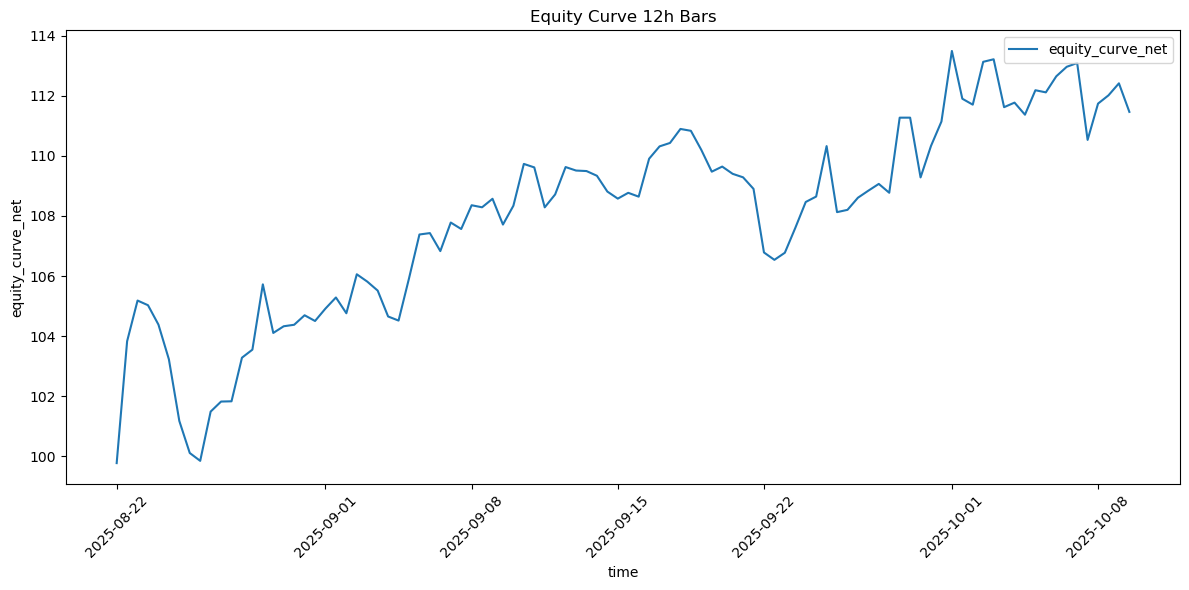

In [247]:
# performance trajectory of our trading strategy using a constant trade size over time.
research.plot_static_timeseries(test_trades, 'Equity Curve', 'equity_curve_net', time_interval)

### evaluate total gross return of using constant trade value

In [248]:
constant_trade_value_gross_return = test_trades['equity_curve_gross'][-1] / capital - 1
constant_trade_value_gross_return

0.17349986433514641

### evaluate total net return of using constant trade value

In [249]:
constant_trade_value_net_return = test_trades['equity_curve_net'][-1] / capital - 1
constant_trade_value_net_return

0.11464781437584581

## experiment with compounding trade sizes

In [250]:
# 2 => 102 (100 + 2)
# 1 => 103 (100 + 2 + 1)
# -1 => 102 (100 + 2 + 1 - 1)

### re-investing profit from previous trade (compounding)

### trade analysis for compounding trade sizes

In [251]:
test_trades = test_trades.with_columns(
    ((pl.col('cum_trade_log_return').exp()) * capital).shift().fill_null(capital).alias('pre_trade_value'),
    ((pl.col('cum_trade_log_return').exp()) * capital).alias('post_trade_value'),
).with_columns(
    (pl.col('pre_trade_value') / pl.col('open')).alias('trade_qty'),
    (pl.col('post_trade_value')-pl.col('pre_trade_value')).alias('trade_gross_pnl'),
)
# test_trades.select('open','trade_log_return','cum_trade_log_return','equity_curve','trade_value','trade_qty')
test_trades.select('datetime','open','close','trade_log_return','pre_trade_value','post_trade_value','trade_gross_pnl')

datetime,open,close,trade_log_return,pre_trade_value,post_trade_value,trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,112272.8,-0.001686,100.0,99.831588,-0.168412
2025-08-22 12:00:00,112272.9,116897.5,0.040366,99.831588,103.943814,4.112226
2025-08-23 00:00:00,116897.5,115266.7,0.014049,103.943814,105.414417,1.470603
2025-08-23 12:00:00,115266.8,115377.1,-0.000957,105.414417,105.31355,-0.100867
2025-08-24 00:00:00,115377.1,114702.0,-0.005868,105.31355,104.697334,-0.616216
…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,-0.025324,119.945687,116.946302,-2.999385
2025-10-08 00:00:00,121286.6,122825.7,0.012611,116.946302,118.430423,1.48412
2025-10-08 12:00:00,122825.8,123237.5,0.003347,118.430423,118.827486,0.397064


### add transaction fees

In [252]:
test_trades = test_trades.with_columns(
    (pl.col('pre_trade_value') * binance.TAKER_FEE + pl.col('post_trade_value') * binance.TAKER_FEE).alias('tx_fees'),
)
test_trades.select('datetime','open','close','trade_log_return','pre_trade_value','post_trade_value','trade_gross_pnl', 'tx_fees')

datetime,open,close,trade_log_return,pre_trade_value,post_trade_value,trade_gross_pnl,tx_fees
datetime[μs],f64,f64,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,112272.8,-0.001686,100.0,99.831588,-0.168412,0.059949
2025-08-22 12:00:00,112272.9,116897.5,0.040366,99.831588,103.943814,4.112226,0.061133
2025-08-23 00:00:00,116897.5,115266.7,0.014049,103.943814,105.414417,1.470603,0.062807
2025-08-23 12:00:00,115266.8,115377.1,-0.000957,105.414417,105.31355,-0.100867,0.063218
2025-08-24 00:00:00,115377.1,114702.0,-0.005868,105.31355,104.697334,-0.616216,0.063003
…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,-0.025324,119.945687,116.946302,-2.999385,0.071068
2025-10-08 00:00:00,121286.6,122825.7,0.012611,116.946302,118.430423,1.48412,0.070613
2025-10-08 12:00:00,122825.8,123237.5,0.003347,118.430423,118.827486,0.397064,0.071177


### add net returns for compounding trade sizes

In [253]:
test_trades = test_trades.with_columns(
    (pl.col('trade_gross_pnl') - pl.col('tx_fees')).alias('trade_net_pnl')
)

### explain compounding (time additivity)

In [254]:
pnl1 = capital * np.exp(0.005349)
pnl1

np.float64(100.5363331442067)

In [255]:
pnl2 = pnl1 * np.exp(0.008597)
pnl2

np.float64(101.40436991002386)

In [256]:
pnl3 = pnl2 * np.exp(0.001385)
pnl3

np.float64(101.5449122654644)

In [257]:
((capital * np.exp(0.005349)) * np.exp(0.008597)) * np.exp(0.001385)

np.float64(101.5449122654644)

In [258]:
capital * np.exp(0.005349 + 0.008597 + 0.001385)

np.float64(101.5449122654644)

In [259]:
# Hopefully you can see that log returns aren’t just some academic thing — they’re actually really practical once you start using them.

### calculate gross total return for compounding trade sizes

In [260]:
compound_gross_return = np.exp(test_trades['cum_trade_log_return'][-1]) - 1
compound_gross_return

np.float64(0.183101934670433)

In [261]:
np.round(compound_gross_return - constant_trade_value_gross_return, 2)

np.float64(0.01)

In [262]:
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return,pre_trade_value,post_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,tx_fees,trade_net_pnl,equity_curve_net,equity_curve_gross
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,113485.9,112130.3,112272.8,-0.001686,-0.005657,-0.009857,0.005205,0.002069,1.0,-0.001686,-0.001686,100.0,99.831588,0.000889,0.000889,-0.168412,0.059949,-0.228362,99.771638,99.831588
2025-08-22 12:00:00,112272.9,117397.4,111625.9,116897.5,0.040366,-0.001686,-0.005657,-0.009857,0.000948,1.0,0.040366,0.03868,99.831588,103.943814,0.000889,0.000891,4.112226,0.061133,4.051094,103.829566,103.950751
2025-08-23 00:00:00,116897.5,116988.0,115180.0,115266.7,-0.014049,0.040366,-0.001686,-0.005657,-0.003571,-1.0,0.014049,0.052729,103.943814,105.414417,0.000889,-0.000855,1.470603,0.062807,1.407796,105.183947,105.365557
2025-08-23 12:00:00,115266.8,115450.0,114510.0,115377.1,0.000957,-0.014049,0.040366,-0.001686,-0.000631,-1.0,-0.000957,0.051772,105.414417,105.31355,0.000915,-0.000868,-0.100867,0.063218,-0.164085,105.02829,105.269871
2025-08-24 00:00:00,115377.1,115640.0,114574.1,114702.0,-0.005868,0.000957,-0.014049,0.040366,0.002658,1.0,-0.005868,0.045903,105.31355,104.697334,0.000913,0.000867,-0.616216,0.063003,-0.679219,104.383341,104.684746
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000779,1.0,-0.025324,0.156545,119.945687,116.946302,0.000964,0.000804,-2.999385,0.071068,-3.070452,110.532028,116.176881
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,0.012611,-0.025324,-0.001858,0.003757,0.003535,1.0,0.012611,0.169155,116.946302,118.430423,0.000964,0.000824,1.48412,0.070613,1.413507,111.740709,117.445943
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,0.003347,0.012611,-0.025324,-0.001858,0.001011,1.0,0.003347,0.172503,118.430423,118.827486,0.000964,0.000814,0.397064,0.071177,0.325886,112.01588,117.781215


### display compounding trade equity curve

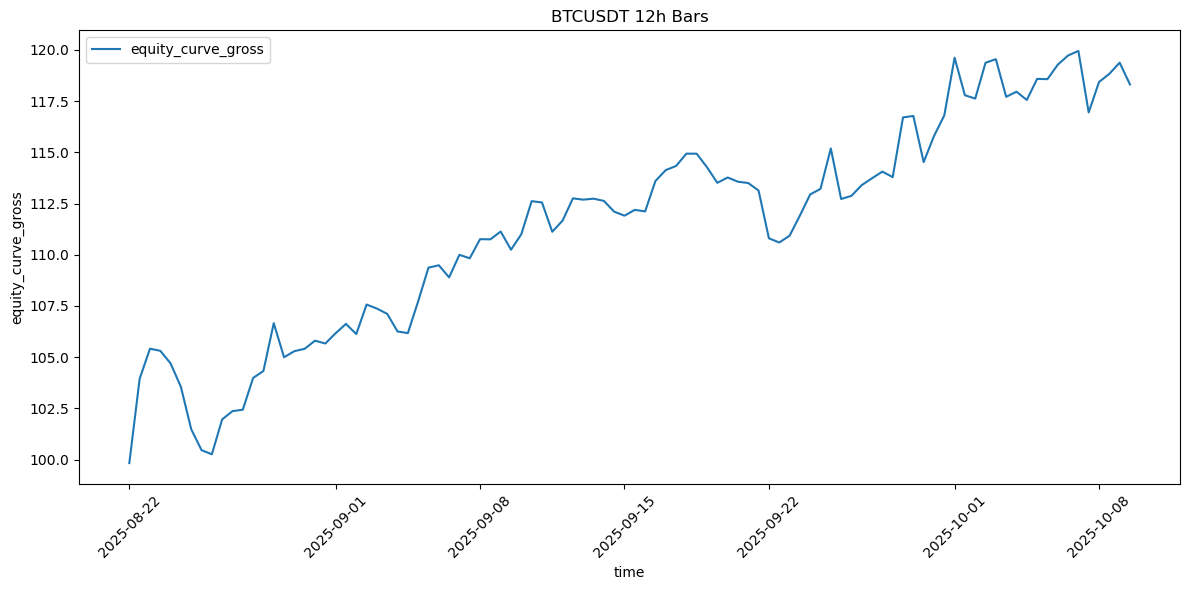

In [263]:
test_trades = test_trades.with_columns((capital+pl.col('trade_gross_pnl').cum_sum()).alias('equity_curve_gross'))
research.plot_static_timeseries(test_trades, sym, 'equity_curve_gross', time_interval)

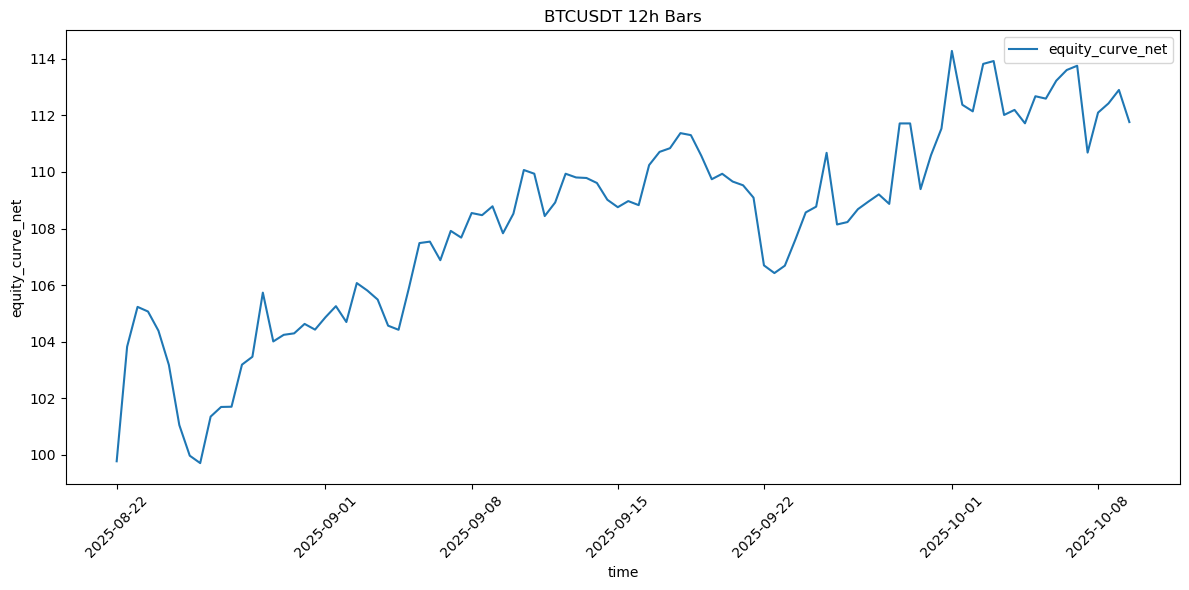

In [264]:
test_trades = test_trades.with_columns((capital+pl.col('trade_net_pnl').cum_sum()).alias('equity_curve_net'))
research.plot_static_timeseries(test_trades, sym, 'equity_curve_net', time_interval)

## Leverage

In [265]:
# what if i told you that we could multiply our pnl by leveraging (which is essentially borrowing money)

In [266]:
# just remember, it amplifies BOTH your profit and losses so it's important to have a postive expected value, and also low standard deviation of returns (minimising risj)

In [267]:
# the idea of chosing a model with a high sharpe is that it reduces risk, reduces the drawdowns, so we can use leverage

In [268]:
# key decision 3: should we use leverage? if so, how much?

In [269]:
capital

100

In [270]:
leverage = 4

In [271]:
capital * leverage

400

In [272]:
test_trades = test_trades.with_columns(
    (pl.col('trade_log_return') *  leverage).alias('trade_lev_log_return')
).with_columns(
    (pl.col('trade_lev_log_return').cum_sum().alias('cum_trade_lev_log_return'))
)
test_trades.select('datetime','trade_log_return','trade_lev_log_return','cum_trade_lev_log_return')

datetime,trade_log_return,trade_lev_log_return,cum_trade_lev_log_return
datetime[μs],f64,f64,f64
2025-08-22 00:00:00,-0.001686,-0.006742,-0.006742
2025-08-22 12:00:00,0.040366,0.161463,0.154721
2025-08-23 00:00:00,0.014049,0.056196,0.210917
2025-08-23 12:00:00,-0.000957,-0.003829,0.207088
2025-08-24 00:00:00,-0.005868,-0.023474,0.183614
…,…,…,…
2025-10-07 12:00:00,-0.025324,-0.101297,0.626179
2025-10-08 00:00:00,0.012611,0.050443,0.676622
2025-10-08 12:00:00,0.003347,0.013388,0.69001


### add trade leveraged pnl

In [273]:
lev_capital = leverage * capital
test_trades = test_trades.with_columns(
    ((pl.col('cum_trade_lev_log_return').exp()) * lev_capital).shift().fill_null(lev_capital).alias('pre_trade_value'),
    ((pl.col('cum_trade_lev_log_return').exp()) * lev_capital).alias('post_trade_value'),
).with_columns(
    (pl.col('pre_trade_value') / pl.col('open')).alias('trade_qty'),
    (pl.col('post_trade_value')-pl.col('pre_trade_value')).alias('trade_gross_pnl'),
)
test_trades.select('datetime','open','close','pre_trade_value','post_trade_value','trade_gross_pnl','cum_trade_lev_log_return')

datetime,open,close,pre_trade_value,post_trade_value,trade_gross_pnl,cum_trade_lev_log_return
datetime[μs],f64,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,112272.8,400.0,397.312205,-2.687795,-0.006742
2025-08-22 12:00:00,112272.9,116897.5,397.312205,466.933018,69.620813,0.154721
2025-08-23 00:00:00,116897.5,115266.7,466.933018,493.923897,26.990879,0.210917
2025-08-23 12:00:00,115266.8,115377.1,493.923897,492.03614,-1.887757,0.207088
2025-08-24 00:00:00,115377.1,114702.0,492.03614,480.62072,-11.41542,0.183614
…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,827.939373,748.179786,-79.759587,0.626179
2025-10-08 00:00:00,121286.6,122825.7,748.179786,786.888335,38.708549,0.676622
2025-10-08 12:00:00,122825.8,123237.5,786.888335,797.494385,10.60605,0.69001


### add transactions fees

In [274]:
test_trades = test_trades.with_columns(
    ((pl.col('pre_trade_value') * binance.TAKER_FEE) + (pl.col('post_trade_value') * binance.TAKER_FEE)).alias('tx_fees'),
).with_columns(
    (pl.col('trade_gross_pnl')-pl.col('tx_fees')).alias('trade_net_pnl')
)
test_trades.select('datetime','open','close','pre_trade_value','post_trade_value','trade_gross_pnl','tx_fees', 'trade_net_pnl','cum_trade_lev_log_return')

datetime,open,close,pre_trade_value,post_trade_value,trade_gross_pnl,tx_fees,trade_net_pnl,cum_trade_lev_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,112272.8,400.0,397.312205,-2.687795,0.239194,-2.926989,-0.006742
2025-08-22 12:00:00,112272.9,116897.5,397.312205,466.933018,69.620813,0.259274,69.361539,0.154721
2025-08-23 00:00:00,116897.5,115266.7,466.933018,493.923897,26.990879,0.288257,26.702622,0.210917
2025-08-23 12:00:00,115266.8,115377.1,493.923897,492.03614,-1.887757,0.295788,-2.183545,0.207088
2025-08-24 00:00:00,115377.1,114702.0,492.03614,480.62072,-11.41542,0.291797,-11.707217,0.183614
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,827.939373,748.179786,-79.759587,0.472836,-80.232423,0.626179
2025-10-08 00:00:00,121286.6,122825.7,748.179786,786.888335,38.708549,0.46052,38.248029,0.676622
2025-10-08 12:00:00,122825.8,123237.5,786.888335,797.494385,10.60605,0.475315,10.130735,0.69001


In [275]:
test_trades = test_trades.with_columns(
    (pl.col('trade_net_pnl').cum_sum()).alias('cum_trade_net_pnl'),
    (capital+(pl.col('trade_net_pnl').cum_sum())).alias('equity_curve_net'),
)
test_trades.select('datetime','open','close','pre_trade_value','post_trade_value','trade_gross_pnl','cum_trade_lev_log_return', 'trade_net_pnl','cum_trade_net_pnl','equity_curve_net')

datetime,open,close,pre_trade_value,post_trade_value,trade_gross_pnl,cum_trade_lev_log_return,trade_net_pnl,cum_trade_net_pnl,equity_curve_net
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-22 00:00:00,112462.2,112272.8,400.0,397.312205,-2.687795,-0.006742,-2.926989,-2.926989,97.073011
2025-08-22 12:00:00,112272.9,116897.5,397.312205,466.933018,69.620813,0.154721,69.361539,66.43455,166.43455
2025-08-23 00:00:00,116897.5,115266.7,466.933018,493.923897,26.990879,0.210917,26.702622,93.137173,193.137173
2025-08-23 12:00:00,115266.8,115377.1,493.923897,492.03614,-1.887757,0.207088,-2.183545,90.953628,190.953628
2025-08-24 00:00:00,115377.1,114702.0,492.03614,480.62072,-11.41542,0.183614,-11.707217,79.246411,179.246411
…,…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,121286.5,827.939373,748.179786,-79.759587,0.626179,-80.232423,313.468741,413.468741
2025-10-08 00:00:00,121286.6,122825.7,748.179786,786.888335,38.708549,0.676622,38.248029,351.716769,451.716769
2025-10-08 12:00:00,122825.8,123237.5,786.888335,797.494385,10.60605,0.69001,10.130735,361.847505,461.847505


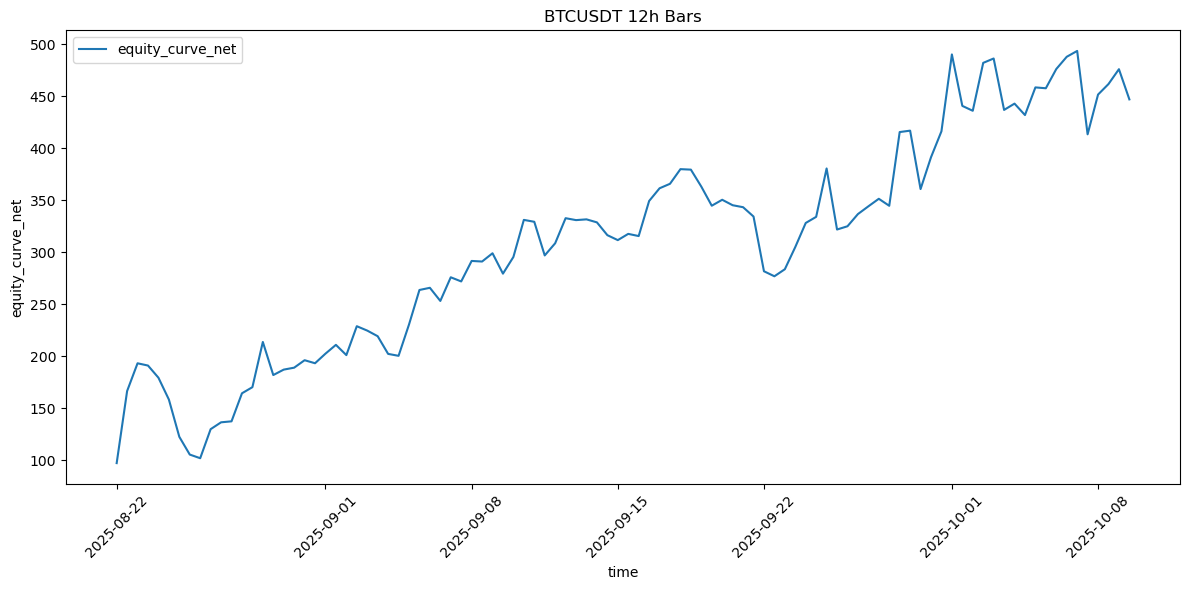

In [276]:
research.plot_static_timeseries(test_trades, sym, 'equity_curve_net', time_interval)

### total leveraged return

In [277]:
test_trades['cum_trade_net_pnl'][-1]/capital

3.4708923498801427

In [278]:
# reason for this huge pnl is the combination of compounding and leverage

In [279]:
### show win rate to show there's no manipulation to make the PnL look good

In [280]:
test_trades.select((pl.col("trade_log_return") > 0).mean())

trade_log_return
f64
0.561224


### factor liquidation (price moves against us too much)

In [281]:
# leverage is a double edged sword. you can amplify profits, but too much leverage and you can wipe out all your money

In [282]:
# Equity = Maintenance Margin
# calulcation differs from different exchanges

In [283]:
maintenance_margin = 0.005

def long_liquidation_price(p, l, mmr):
    return (p * l) / (l + 1 - mmr * l)

def short_liquidation_price(p, l, mmr):
    return (p * l) / (l - 1 + mmr * l)

### show how leverage affects long positions

In [284]:
long_liquidation_price(200, 2, maintenance_margin)

133.7792642140468

In [285]:
long_liquidation_price(200, 4, maintenance_margin)

160.64257028112448

In [286]:
long_liquidation_price(200, 10, maintenance_margin)

182.64840182648402

In [287]:
long_liquidation_price(200, 50, maintenance_margin)

197.04433497536945

### show how leverage affects short positions

In [288]:
short_liquidation_price(200, 2, maintenance_margin)

396.03960396039605

In [289]:
short_liquidation_price(200, 4, maintenance_margin)

264.9006622516556

In [290]:
short_liquidation_price(200, 10, maintenance_margin)

220.99447513812152

In [291]:
short_liquidation_price(200, 60, maintenance_margin)

202.36087689713324

### add liquidation prices to our trades

In [292]:
leverage = 4
test_trades = test_trades.with_columns(
    pl.when(pl.col("dir_signal") == 1)  # long position
      .then(
          (pl.col("open") * leverage)
          / (leverage + 1 - maintenance_margin * leverage)
      )
      .when(pl.col("dir_signal") == -1)  # short position
      .then(
          (pl.col("open") * leverage)
          / (leverage - 1 + maintenance_margin * leverage)
      )
      .otherwise(None)
      .alias("liquidation_price")
)
test_trades.select('datetime','open','high','low','close','liquidation_price','dir_signal')

datetime,open,high,low,close,liquidation_price,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f32
2025-08-22 00:00:00,112462.2,113485.9,112130.3,112272.8,90331.084337,1.0
2025-08-22 12:00:00,112272.9,117397.4,111625.9,116897.5,90179.036145,1.0
2025-08-23 00:00:00,116897.5,116988.0,115180.0,115266.7,154831.125828,-1.0
2025-08-23 12:00:00,115266.8,115450.0,114510.0,115377.1,152671.258278,-1.0
2025-08-24 00:00:00,115377.1,115640.0,114574.1,114702.0,92672.369478,1.0
…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,99917.349398,1.0
2025-10-08 00:00:00,121286.6,123150.0,121005.3,122825.7,97418.955823,1.0
2025-10-08 12:00:00,122825.8,124170.6,121607.8,123237.5,98655.261044,1.0


In [296]:
test_trades = test_trades.with_columns([
    # Worst price based on direction
    pl.when(pl.col("dir_signal") == 1)
      .then(pl.col("low"))
      .otherwise(pl.col("high"))
      .alias("worst_price"),

    # Liquidation flag
    pl.when(
        (pl.col("dir_signal") == 1) & (pl.col("low") <= pl.col("liquidation_price"))
    )
    .then(True)
    .when(
        (pl.col("dir_signal") == -1) & (pl.col("high") >= pl.col("liquidation_price"))
    )
    .then(True)
    .otherwise(False)
    .alias("liquidated")
])
test_trades.select('datetime','open','low','high','close','dir_signal','worst_price','liquidation_price','liquidated')

datetime,open,low,high,close,dir_signal,worst_price,liquidation_price,liquidated
datetime[μs],f64,f64,f64,f64,f32,f64,f64,bool
2025-08-22 00:00:00,112462.2,112130.3,113485.9,112272.8,1.0,112130.3,90331.084337,false
2025-08-22 12:00:00,112272.9,111625.9,117397.4,116897.5,1.0,111625.9,90179.036145,false
2025-08-23 00:00:00,116897.5,115180.0,116988.0,115266.7,-1.0,116988.0,154831.125828,false
2025-08-23 12:00:00,115266.8,114510.0,115450.0,115377.1,-1.0,115450.0,152671.258278,false
2025-08-24 00:00:00,115377.1,114574.1,115640.0,114702.0,1.0,114574.1,92672.369478,false
…,…,…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,120516.0,125098.0,121286.5,1.0,120516.0,99917.349398,false
2025-10-08 00:00:00,121286.6,121005.3,123150.0,122825.7,1.0,121005.3,97418.955823,false
2025-10-08 12:00:00,122825.8,121607.8,124170.6,123237.5,1.0,121607.8,98655.261044,false


In [294]:
test_trades.filter(pl.col("liquidated") == True)

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return,pre_trade_value,post_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,tx_fees,trade_net_pnl,equity_curve_net,equity_curve_gross,trade_lev_log_return,cum_trade_lev_log_return,cum_trade_net_pnl,liquidation_price,worst_price,liquidated
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool


### should we use a stop-loss?

In [ ]:
# we should only use stop loss if it increases our expected value. let's create a stop loss and see if it improves.

In [301]:
stop_loss_delta = 500
test_trades = test_trades.with_columns(
    pl.when(
        (pl.col("dir_signal") == 1)
        
    )
    .then(pl.col('open') - stop_loss_delta)
    .otherwise(pl.col('open') + stop_loss_delta)
    .alias('stop_loss')
)
test_trades.select('datetime','open','low','high','close','dir_signal','stop_loss')


datetime,open,low,high,close,dir_signal,stop_loss
datetime[μs],f64,f64,f64,f64,f32,f64
2025-08-22 00:00:00,112462.2,112130.3,113485.9,112272.8,1.0,111962.2
2025-08-22 12:00:00,112272.9,111625.9,117397.4,116897.5,1.0,111772.9
2025-08-23 00:00:00,116897.5,115180.0,116988.0,115266.7,-1.0,117397.5
2025-08-23 12:00:00,115266.8,114510.0,115450.0,115377.1,-1.0,115766.8
2025-08-24 00:00:00,115377.1,114574.1,115640.0,114702.0,1.0,114877.1
…,…,…,…,…,…,…
2025-10-07 12:00:00,124397.1,120516.0,125098.0,121286.5,1.0,123897.1
2025-10-08 00:00:00,121286.6,121005.3,123150.0,122825.7,1.0,120786.6
2025-10-08 12:00:00,122825.8,121607.8,124170.6,123237.5,1.0,122325.8


In [295]:
# topics we haven't covered
# alpha decay (also known as model drift) => where the performance drifts => 
# market impact => we are not trading big sizes => if we were, we could potentially move markets against us
# funding fees/rebates
# slippage => we may not always get the best price, we may get executed at prices below top of the book (best bid/ask)

# spread => BTCUSDT has quite tight spreads => so we have nominal spread costs